# Importing and Pre-processing the Data

### Importing

In [233]:
import pandas as pd
import numpy as np
import re
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Gensim
import gensim
from gensim.utils import simple_preprocess
# NLTK
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [234]:
# define our color pallete so it is more visually pleasing and consistent through the graphs
import matplotlib.colors as clr
purples = clr.LinearSegmentedColormap.from_list('purples', ['#A020F0', '#C16EF5'], N=10)
blues = clr.LinearSegmentedColormap.from_list('purples', ['#2234f5', '#626ef5'], N=10)
reds = clr.LinearSegmentedColormap.from_list('purples', ['#f52525', '#f57676'], N=10)

In [169]:
# load in the full-size df
df = pd.read_hdf('full_df.h5', index_col=0)

In [235]:
print(df.shape)
df.head()

(879279, 13)


,tweet,author,party,chamber,congress,retweet,tidy_tweet,date,tidy_tweet_tokens,tokens_no_stop,has_religious,rel_words,n_tokens
0,VIDEO: Today's press conference w/ @SenBobCork...,"Alexander, Lamar (TN)",D,H,112,0,VIDEO Today s press conference w on the is...,2012-12-28,"[video, today, press, conference, on, the, is,...","[press, conference, website]",False,[],3
1,Will hold press conference in the Capitol's Ra...,"Alexander, Lamar (TN)",D,H,112,0,Will hold press conference in the Capitol s Ra...,2012-12-28,"[will, hold, press, conference, in, the, capit...","[hold, press, conference, capitol, radio, tv, ...",False,[],10
2,"""Major threats to our research universities"" O...","Alexander, Lamar (TN)",D,H,112,1,Major threats to our research universities O...,2012-12-19,"[major, threats, to, our, research, universiti...","[major, threats, our, research, universities, ...",False,[],12
3,".@SenAlexander The Wind #PTC is ""a brazen flee...","Alexander, Lamar (TN)",D,H,112,1,The Wind is a brazen fleecing of the taxpa...,2012-12-19,"[the, wind, is, brazen, fleecing, of, the, tax...","[wind, brazen, fleecing, taxpayers]",False,[],4
4,VIDEO: Sen. Alexander on passing of Sen. @Dani...,"Alexander, Lamar (TN)",D,H,112,0,VIDEO Sen Alexander on passing of Sen S...,2012-12-18,"[video, sen, alexander, on, passing, of, sen, ...","[sen, alexander, passing, sen, senator, inouye...",False,[],11


In [223]:
# original import of raw data
df_full = pd.read_csv("congress-tweets.csv", encoding='utf-8')
len(df_full)

885832

In [2]:
# smaller, sampled df
df = pd.read_hdf('sampled_df.h5', index_col=0)

In [236]:
df.to_hdf('full_df.h5', key='full_df')

C:\Users\prest\anaconda3\lib\site-packages\pandas\core\generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tweet', 'author', 'party', 'chamber', 'tidy_tweet',
       'tidy_tweet_tokens', 'tokens_no_stop', 'rel_words'],
      dtype='object')]

  pytables.to_hdf(


### Pre-processing

In [224]:
# pre processing function of the tweets
# just combined it all into one function so it is less messy

def pre_process_df(df):
    df['tidy_tweet'] = df['tweet'].str.lower()
    # REMOVE '@USER'
    print('Removing Users from Tweets')
    df['tidy_tweet'] = np.vectorize(remove_users)(df['tweet'],"@ [\w]*", "@[\w]*")
    # REMOVE HASHTAGS
    print('Removing Hashtags from Tweets')
    df['tidy_tweet'] = np.vectorize(remove_hashtags)(df['tidy_tweet'], "# [\w]*", "#[\w]*")
    # REMOVE LINKS
    print('Removing Links from Tweets')
    df['tidy_tweet'] = np.vectorize(remove_links)(df['tidy_tweet'])
    # EXTRACT TWEET DATE
    print('Extracting Dates from Tweets')
    df['date'] = df['tweet'].str.extract(r"([A-Z][a-z]+\s\d+,\s\d+)\s*$")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # REMOVE Punctuations, Numbers, and Special Characters
    print('Removing Punctuation, Numbers, and Special Characters from Tweets')
    df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    # TOKENIZATION
    print('Tokenizing Tweets')
    df['tidy_tweet_tokens'] = list(tokenize(df['tidy_tweet']))
    # REMOVE STOPWORDS
    print('Removing Stop Words from Tweets')
    df['tokens_no_stop'] = remove_stopwords(df['tidy_tweet_tokens'])
    # DROP EMPTY TWEETS
    print('Dropping Empty Tweets')
    df = df[df['tokens_no_stop'].apply(lambda x: len(x)) > 0]
    # ADDING NUMBER OF TOKENS COLUMN
    print('Adding "n_tokens" Column')
    df['n_tokens'] = df['tokens_no_stop'].apply(lambda x: len(x))
    # FIND AND EXTRACT RELIGIOUS WORDS
    print('Finding and Extracting Religious Words')
    religious_words = pd.read_csv('religious_words.csv', squeeze=True)
    df['rel_words'] = df['tokens_no_stop'].apply(lambda x: list(set(religious_words) & set(x)))
    df['has_religious'] = df['rel_words'].apply(lambda x: len(x) != 0)
    print('DataFrame Finished')
    return df
    
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
  
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_hashtags(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))
        
def remove_stopwords(tweets):
    # Prepare Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'https', 'twitter', 'religions', 'pic','twitt','today','will','thank', 'thanks',
                      'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec', 'great', 'new', 'day', 'rt',
                      'th', 'morning', 'week', 'com', 'net', 'video'])
    #words to remove from stopwords
    remove_words = ['we','our','ours','ourselves']
    stop_words = [e for e in stop_words if e not in remove_words]
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]

In [225]:
df = pre_process_df(df)
# for some reason these two tweets are concatenations of other tweets. these are the only two tweets like this.
df.drop(index=[314465, 427339], inplace=True)

Users Removed from Tweets
Hashtags Removed from Tweets
Links Removed from Tweets
Dates Extracted
Punctuation, Numbers, and Special Characters Removed from Tweets
Tokenized
Stop Words Removed from Tweets
Empty Tweets Dropped


<ipython-input-224-dee0f8fcd151>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_tokens'] = df['tokens_no_stop'].apply(lambda x: len(x))


Found and Extracted Religious Words
DataFrame Finished
index 314465, 427339 not in this sample


<ipython-input-224-dee0f8fcd151>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rel_words'] = df['tokens_no_stop'].apply(lambda x: list(set(religious_words) & set(x)))
<ipython-input-224-dee0f8fcd151>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_religious'] = df['rel_words'].apply(lambda x: len(x) != 0)


In [226]:
# CREATE df_religious DATAFRAME
df_religious = df[df['has_religious']]

### Authors Dataframe

In [173]:
authors = pd.read_hdf('authors.h5', key='authors')

In [227]:
authors = df.pivot_table(index=['author', 'party', 'chamber'], values=['retweet', 'has_religious', 'n_tokens'])
authors = authors.reset_index(level=['party', 'chamber'])

In [269]:
authors

,party,chamber,has_religious,n_tokens,retweet
author,,,,,
"Adams, Sandy (FL-24)",R,H,0.010101,8.622896,0.047138
"Aderholt, Rob (AL-4)",D,H,0.053508,8.895363,0.165279
"Aderholt, Rob (AL-4)",R,H,0.053508,8.895363,0.165279
"Aderholt, Robert (AL-04)",R,H,0.062500,9.077206,0.110294
"Akaka, Daniel (HI)",D,S,0.007772,10.126943,0.116580
...,...,...,...,...,...
"Young, Don (AK-AL)",D,H,0.027027,8.683047,0.120393
"Young, Don (AK-AL)",R,H,0.020604,8.337912,0.171703
"Young, Todd (IN-09)",R,H,0.013529,9.213078,0.057497


### Tokens Arrays

In [250]:
# create separate dfs for democrats and republicans
dems = df[df['party'] == 'D']
reps = df[df['party'] == 'R']

# create ndarrays for the democrat and republican tokens
tokens = np.concatenate(df['tokens_no_stop'].values)
dem_tokens = np.concatenate(dems['tokens_no_stop'].values)
rep_tokens = np.concatenate(reps['tokens_no_stop'].values)

### Number of Dems/Reps in Dataset

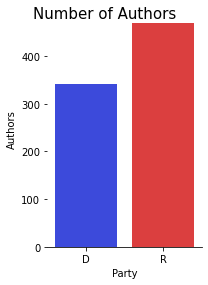

In [253]:
g = sns.catplot(data=authors, x='party', kind='count', palette=[blues(0), reds(0)], order=['D', 'R'], height=4, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Party", "Authors")
g.fig.suptitle("Number of Authors", fontsize=15)
g.savefig('number_of_authors')

### Total Tweets

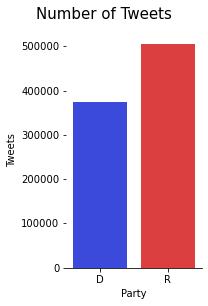

In [254]:
g = sns.catplot(data=df, x='party', kind='count', palette=[blues(0), reds(0)], order=['D', 'R'], height=4, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Party", "Tweets")
g.fig.suptitle("Number of Tweets", fontsize=15, y=1.05)
g.savefig('number_of_tweets')

### Total Words

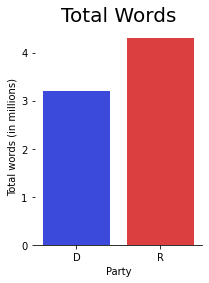

In [256]:
# total number of words in the dataset for democrats and republicans
plt.figure(figsize=(3,4)) 
sns.barplot(x=['D', 'R'], 
            y=[len(dem_tokens)/10**6, len(rep_tokens)/10**6], 
            palette=[blues(0), reds(0)])
plt.ylabel('Total words (in millions)')
plt.xlabel('Party')
plt.title('Total Words', fontsize=20)
sns.despine(left=True)
plt.savefig('total_words')

### Average words per tweet

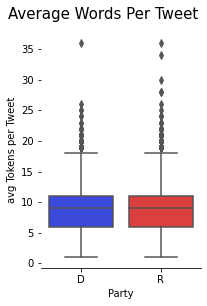

In [260]:
g = sns.catplot(data=df, kind="box", x="party", y='n_tokens', palette=[blues(0), reds(0)], height=4, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Party", "avg Tokens per Tweet")
g.fig.suptitle("Average Words Per Tweet", fontsize=15, y=1.05)
g.savefig('avg_words_per_tweet')

## Religious Words

### Religious Tweets by Chamber (house/congress)

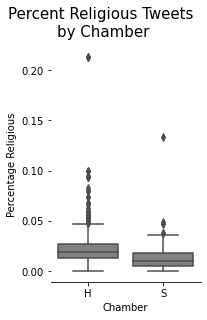

In [262]:
g = sns.catplot(data=authors, kind="box", x="chamber", y='has_religious', height=4, aspect=3/4, color='gray')
g.despine(left=True)
g.set_axis_labels("Chamber", "Percentage Religious")
g.fig.suptitle("Percent Religious Tweets \nby Chamber", fontsize=15, y=1.1)
g.savefig('rel_tweets_by_chamber')

### Religious tweets by party

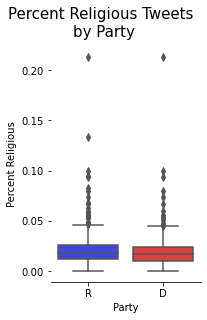

In [266]:
g = sns.catplot(data=authors, kind="box", x="party", y='has_religious', palette=[blues(0), reds(0)], height=4, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Party", "Percent Religious")
g.fig.suptitle("Percent Religious Tweets \nby Party", fontsize=15, y=1.1)
g.savefig('rel_tweet_party')

### Percentage religious tweets by party and chamber

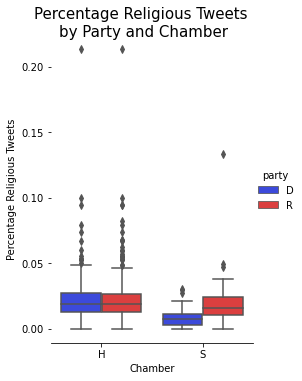

In [264]:
g = sns.catplot(data=authors, kind="box", x="chamber", y="has_religious", hue="party", 
                hue_order=['D', 'R'], palette=[blues(0), reds(0)], height=5, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Chamber", "Percentage Religious Tweets")
g.fig.suptitle("Percentage Religious Tweets \nby Party and Chamber", fontsize=15, y=1.05)
g.savefig('rel_party_and_chamber')

### Top 100 Most Religious Tweeters

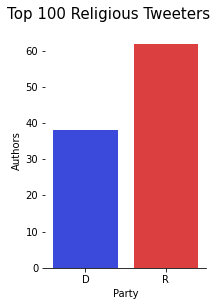

In [268]:
g = sns.catplot(data=authors.sort_values(by='has_religious', ascending=False)[:100], x='party', kind='count', 
            palette=[blues(0), reds(0)], height=4, aspect=3/4)
g.despine(left=True)
g.set_axis_labels("Party", "Authors")
g.fig.suptitle("Top 100 Religious Tweeters", fontsize=15, y=1.05)
g.savefig('top_100_rel_tweeters')

# Cool, but won't use

### Normalized Word Frequency

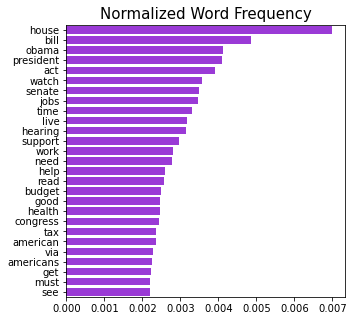

In [191]:
# the 30 most used words in the entire dataset (both democrats and republicans)
value_counts = pd.Series(list(tokens)).value_counts()[:30]
# our, we, and us aren't necessary for this part of the analysis, we will drop them for this visualization
value_counts.drop(['our', 'we', 'us'], inplace=True)

# plot the value_counts
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Normalized Word Frequency', fontsize=15)
sns.barplot(x=value_counts.values/len(tokens), y=value_counts.index, width=.75, color=purples(0))
plt.savefig('word_freq_all_full')

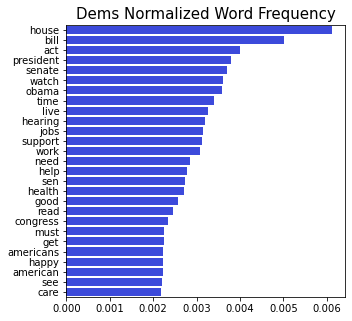

In [192]:
# the 30 most used words for democrats
dem_value_counts = pd.Series(list(dem_tokens)).value_counts()[:30]
# our, we, and us aren't necessary for this part of the analysis, we will drop them for this visualization
dem_value_counts.drop(['our', 'we', 'us'], inplace=True)

# plot the value counts
plt.figure(figsize = (5, len(dem_value_counts)//5), facecolor = None)
plt.title('Dems Normalized Word Frequency', fontsize=15)
sns.barplot(x=dem_value_counts.values/len(dem_tokens), y=dem_value_counts.index, color=blues(0))
plt.savefig('word_freq_dem_full')

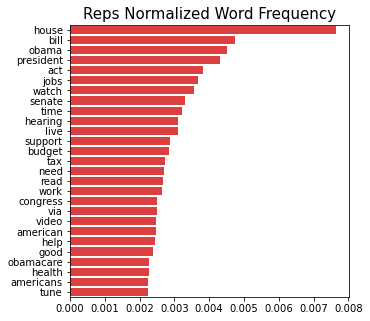

In [193]:
# the 30 most used words for republicans
rep_value_counts = pd.Series(list(rep_tokens)).value_counts()[:30]
# our, we, and us aren't necessary for this part of the analysis, we will drop them for this visualization
rep_value_counts.drop(['our', 'we', 'us'], inplace=True)

# plot the value counts
plt.figure(figsize = (5, len(rep_value_counts)//5), facecolor = None)
plt.title('Reps Normalized Word Frequency', fontsize=15)
sns.barplot(x=rep_value_counts.values/len(rep_tokens), y=rep_value_counts.index, color=reds(0))
plt.savefig('word_freq_rep_full')

### Word Frequency Breakdown (religious associated words)

In [44]:
dem_rel = df_religious[df_religious['party'] == 'D']
rep_rel = df_religious[df_religious['party'] == 'R']

In [45]:
rel_tokens = np.concatenate(df_religious['tokens_no_stop'].values)
rel_dem_tokens = np.concatenate(dem_rel['tokens_no_stop'].values)
rel_rep_tokens = np.concatenate(rep_rel['tokens_no_stop'].values)

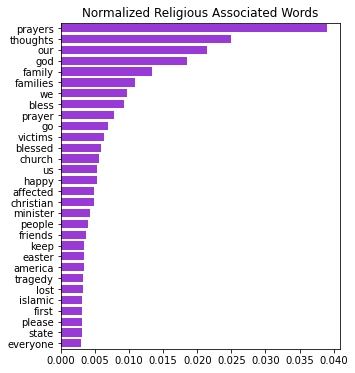

In [46]:
value_counts = pd.Series(list(rel_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Normalized Religious Associated Words')
sns.barplot(x=value_counts.values/len(rel_tokens), y=value_counts.index, width=.75, color=purples(0))
plt.savefig('religious_assoc_words_normalized')

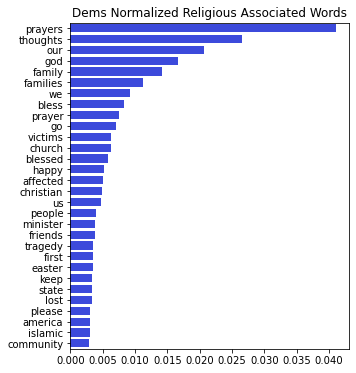

In [48]:
value_counts = pd.Series(list(rel_dem_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Dems Normalized Religious Associated Words')
sns.barplot(x=value_counts.values/len(rel_dem_tokens), y=value_counts.index, width=.75, color=blues(0))
plt.savefig('dems_religious_assoc_words_normalized')

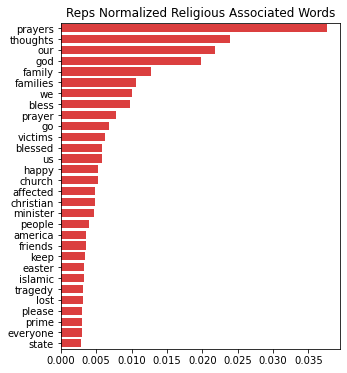

In [51]:
value_counts = pd.Series(list(rel_rep_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Reps Normalized Religious Associated Words')
sns.barplot(x=value_counts.values/len(rel_rep_tokens), y=value_counts.index, width=.75, color=reds(0))
plt.savefig('reps_religious_assoc_words_percentages')

### Word Frequency Breakdown (religious words only)

In [53]:
rel_tokens = np.concatenate(df_religious['rel_words'].values)
rel_dem_tokens = np.concatenate(dem_rel['rel_words'].values)
rel_rep_tokens = np.concatenate(rep_rel['rel_words'].values)

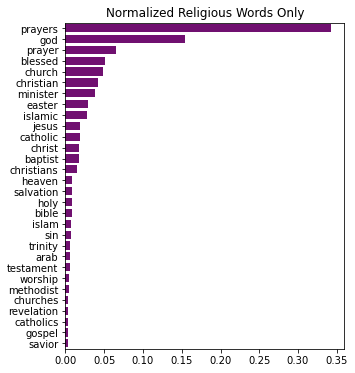

In [58]:
value_counts = pd.Series(list(rel_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Normalized Religious Words Only')
sns.barplot(x=value_counts.values/len(rel_tokens), y=value_counts.index, width=.75, color='purple')
plt.savefig('only_religious_words_normalized')

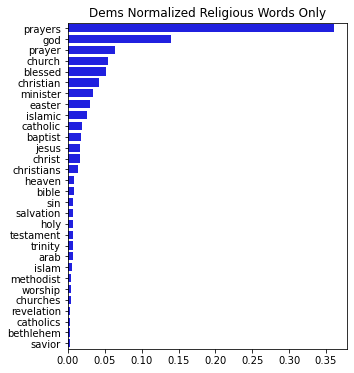

In [59]:
value_counts = pd.Series(list(rel_dem_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Dems Normalized Religious Words Only')
sns.barplot(x=value_counts.values/len(rel_dem_tokens), y=value_counts.index, width=.75, color='blue')
plt.savefig('dems_only_religious_words_normalized')

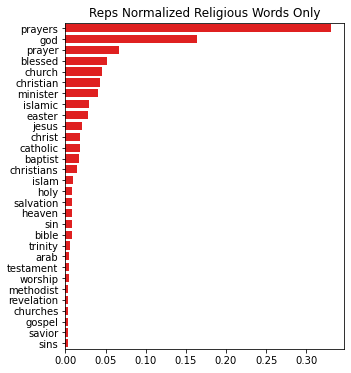

In [60]:
value_counts = pd.Series(list(rel_rep_tokens)).value_counts()[:30]
plt.figure(figsize = (5, len(value_counts)//5), facecolor = None)
plt.title('Reps Normalized Religious Words Only')
sns.barplot(x=value_counts.values/len(rel_rep_tokens), y=value_counts.index, width=.75, color='red')
plt.savefig('reps_only_religious_words_normalized')

# Word Cloud (For Title Slide)

In [246]:
# word cloud requires a string reparated by spaces
words_for_cloud = " ".join(tokens)+" "
words_for_cloud_dem = " ".join(dem_tokens)+" "
words_for_cloud_rep = " ".join(rep_tokens)+" "

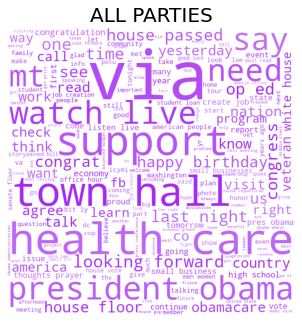

In [247]:
# generating word cloud for both democrats and republicans (purple)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', colormap=purples,
                min_font_size = 10).generate(words_for_cloud)
 
plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('ALL PARTIES', fontsize=20)
 
plt.show()
wordcloud.to_file('all_parties_wordcloud_full.png')

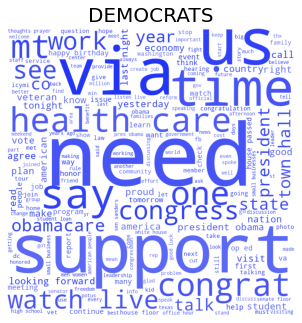

In [248]:
# generating word cloud for democrats (blue)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', colormap=blues,
                min_font_size = 10).generate(words_for_cloud_dem)

plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('DEMOCRATS', fontsize=20)
 
plt.show()
wordcloud.to_file('democrats_wordcloud_full.png')

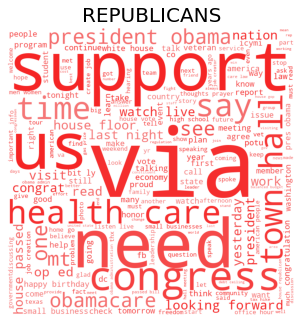

In [249]:
# generating word cloud for republicans (red)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', colormap=reds,
                min_font_size = 10).generate(words_for_cloud_rep)

plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('REPUBLICANS', fontsize=20)
 
plt.show()
wordcloud.to_file('republicans_wordcloud_full.png')

# Try Classification Again

In [107]:
df['pre_processed_data'] = df['tokens_no_stop'].str.join(' ')

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

data = df['pre_processed_data'].values
label = df['party'].values

train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.3, random_state=2)

In [111]:
nb_model = make_pipeline(CountVectorizer(binary=True), MultinomialNB())
nb_model.fit(train_data, train_label)

Pipeline(steps=[('countvectorizer', CountVectorizer(binary=True)),
                ('multinomialnb', MultinomialNB())])

In [112]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_data, train_label)

DummyClassifier(strategy='most_frequent')

In [113]:
q3_score = nb_model.score(test_data, test_label) # float: test classification accuracy score of the model
q3b_score = dummy_clf.score(test_data, test_label) # float: test classification accuracy score of the baseline

# Leave these lines here to print the result
print("Model test classification accuracy:", q3_score)
print("Baseline test classification accuracy:", q3b_score)

Model test classification accuracy: 0.5823328911798781
Baseline test classification accuracy: 0.5774803969306714


Other Stuffs

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['pre_processed_data'])

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['party'], test_size=0.3, random_state=123)

In [116]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Baseline test classification accuracy:", q3b_score)

MultinomialNB Accuracy: 0.5926087613546687
Baseline test classification accuracy: 0.5774803969306714


In [3]:
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df, df['party'], test_size=0.3, random_state=123)

In [205]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

X_train = labelizeTweets(X_train, 'TRAIN')
X_test = labelizeTweets(X_test, 'TEST')

AttributeError: module 'gensim.models.doc2vec' has no attribute 'LabeledSentence'

In [183]:
# min_count=3, sg = 1, window=7
filtered_lines = X_train['tokens_no_stop'].values
w = w2v(sentences = filtered_lines)       

In [184]:
w.wv.key_to_index

{'our': 0,
 'we': 1,
 'house': 2,
 'bill': 3,
 'president': 4,
 'obama': 5,
 'act': 6,
 'us': 7,
 'watch': 8,
 'senate': 9,
 'jobs': 10,
 'time': 11,
 'live': 12,
 'hearing': 13,
 'support': 14,
 'work': 15,
 'need': 16,
 'read': 17,
 'health': 18,
 'help': 19,
 'good': 20,
 'congress': 21,
 'tax': 22,
 'budget': 23,
 'american': 24,
 'must': 25,
 'americans': 26,
 'obamacare': 27,
 'via': 28,
 'get': 29,
 'happy': 30,
 'discuss': 31,
 'video': 32,
 'last': 33,
 'see': 34,
 'pm': 35,
 'office': 36,
 'care': 37,
 'people': 38,
 'sen': 39,
 'tune': 40,
 'vote': 41,
 'passed': 42,
 'one': 43,
 'meeting': 44,
 'tonight': 45,
 'state': 46,
 'year': 47,
 'join': 48,
 'job': 49,
 'plan': 50,
 'proud': 51,
 'spending': 52,
 'floor': 53,
 'would': 54,
 'like': 55,
 'rep': 56,
 'law': 57,
 'national': 58,
 'energy': 59,
 'news': 60,
 'america': 61,
 'families': 62,
 'keep': 63,
 'tomorrow': 64,
 'debt': 65,
 'talk': 66,
 'check': 67,
 'economy': 68,
 'co': 69,
 'service': 70,
 'make': 71,
 'firs

In [185]:
print(w.wv.most_similar('community'))

[('assoc', 0.7440869212150574), ('educators', 0.7309499382972717), ('professionals', 0.7160816788673401), ('youth', 0.709441602230072), ('volunteers', 0.6907646059989929), ('area', 0.6907616257667542), ('communities', 0.6846391558647156), ('association', 0.6787053942680359), ('volunteer', 0.6763908863067627), ('counselors', 0.6753164529800415)]


In [177]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [w.wv[word] for word in list(w.wv.key_to_index)[:1000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(w.wv.key_to_index)[:1000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.021s...
[t-SNE] Computed neighbors for 1000 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.076039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.920471
[t-SNE] KL divergence after 1000 iterations: 1.491723


In [187]:
# building tf-idf matrix 
vectorizer = TfidfVectorizer(min_df=10)
# matrix = vectorizer.fit_transform([x.words for x in X_train])
matrix = vectorizer.fit_transform(X_train['pre_processed_data'])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

vocab size : 9085


In [188]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [200]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(X_train['tokens_no_stop'], X_test))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]


TypeError: 'Series' object is not callable

In [203]:
map(X_train['tokens_no_stop'], X_test)

In [116]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Baseline test classification accuracy:", q3b_score)

MultinomialNB Accuracy: 0.5926087613546687
Baseline test classification accuracy: 0.5774803969306714


In [141]:
# Unique ID of the word
query_word = 'religion'
print("Index of the word", query_word)
print(w.wv.key_to_index[query_word])
# Total number of the words 
print(len(w.wv.key_to_index))
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w.wv[query_word]))

Index of the word religion
4260
16611
Length of the vector generated for a word
100


In [143]:
emb_df = (pd.DataFrame([w.wv.get_vector(str(n)) for n in w.wv.key_to_index],index = w.wv.key_to_index))
print(emb_df.shape)
emb_df.head()

(16611, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
our,1.070760,0.325571,1.193099,2.566163,-0.977201,-0.383961,0.798205,1.417024,-1.377232,-0.728594,...,0.193705,0.625514,0.629348,1.417931,-0.092715,-0.051292,-1.218122,-0.221755,-1.595130,0.493718
we,1.324048,0.397283,0.708408,0.455871,1.033912,-0.410837,0.420820,1.491829,-1.644401,0.069073,...,0.705769,1.239558,0.293303,0.456430,-0.083984,-0.104699,0.451872,1.213585,-2.288532,0.297692
house,0.684576,1.275239,-1.011310,-0.340593,0.735484,1.516457,-0.981299,1.450576,-1.840786,0.366629,...,0.632657,1.580444,1.825545,2.064918,1.918953,-0.792977,0.515167,-0.270702,0.568371,-1.042821
bill,3.041535,1.893282,0.140134,-1.229263,0.097280,-0.431760,-0.174846,3.015607,1.518377,-0.794879,...,-0.885838,0.307571,0.718005,1.606065,1.409756,-1.655414,1.127797,-1.395968,0.124681,-1.120092
president,-0.215919,1.472266,-2.404221,0.398328,0.653888,-0.172182,0.956753,0.333430,-2.979373,-0.491912,...,2.553267,-0.854544,-1.830601,-0.305329,1.260466,-3.750298,0.312079,-0.130310,-1.476925,-0.383498


In [218]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['tokens_no_stop'], df['party'], test_size=0.3, random_state=123)

In [219]:
w = w2v(sentences = X_train)       

In [221]:
word2vec_file = []
for index, row in X_train:
    model_vector = (np.mean([w.wv[token] for token in row['tokens_no_stop']], axis=0)).tolist()
    if index == 0:
        header = ",".join(str(ele) for ele in range(1000))
        word2vec_file.write(header)
        word2vec_file.write("\n")
    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
    else:
        line1 = ",".join([str(0) for i in range(1000)])
    word2vec_file.append(line1)

ValueError: too many values to unpack (expected 2)

In [240]:
X_train[:5].apply(lambda x: np.mean([print(w.wv[token]) for token in x], axis=0))

[-1.6919923   0.3714983  -0.51234645  0.06962162  2.1093228  -0.65382016
 -0.88860774  2.0328965  -0.46586767  0.6478289   0.21549103 -0.72803384
 -1.1635325   2.3953424   0.06372695 -1.2738762  -0.82727754 -0.3013087
  1.5077192  -1.842655    2.200907   -0.7926729  -0.01411707  0.82403994
 -0.37796718  0.51796824  1.3198849   0.6164454  -0.79698247 -2.247772
  0.40313658  1.6544118  -1.0633128   0.24146228  2.339932   -0.34462947
  0.54225    -0.76326466 -0.10003366  0.15679766  0.27792972  0.2945629
  0.24801615 -0.9995285   2.0061073  -0.7571606   0.78527856 -0.5374225
  0.89058745 -2.564652    0.445872    0.31696427  0.61569256  0.21289891
  1.9121288   0.32397836  0.04451586 -0.13533546  0.5570333   0.215709
  1.4395288  -1.327733   -0.1948616  -1.5758663   0.26892856 -0.1812597
  0.16835178  1.2228539  -1.3554116   2.5481286   0.16689913  0.62852985
  0.45553422  0.6463241   1.7818794   1.2851717  -0.75557977 -0.01615557
 -0.29079303 -0.7339247  -2.2054217  -0.04451727 -0.1360306

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [1]:
# import modules & set up logging
import gensim

sentences = [['first', 'sentence'], ['second', 'sentence']]
# train word2vec on the two sentences
model = gensim.models.Word2Vec(sentences, min_count=1)

In [ ]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()
 
sentences = MySentences('/some/directory') # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences)

In [137]:
df.head()

,tweet,author,party,chamber,congress,retweet,tidy_tweet,tidy_tweet_tokens,tokens_no_stop
466814,Great meeting with #Hammonton Gazette today to...,"LoBiondo, Frank A. (NJ-02)",R,H,112,0,Great meeting with #Hammonton Gazette today to...,"[great, meeting, with, gazette, today, to, dis...","[meeting, gazette, discuss, many, issues, incl..."
623772,Oversight is critical to ensure tax $s not was...,"Franks, Trent (AZ-8)",R,H,113,0,Oversight is critical to ensure tax $s not was...,"[oversight, is, critical, to, ensure, tax, not...","[oversight, critical, ensure, tax, wasted, wat..."
613080,TOMORROW AT 10:30 AM: Examining Data Security ...,"Fincher, Stephen (TN-8)",R,H,113,1,TOMORROW AT 10:30 AM: Examining Data Security ...,"[tomorrow, at, am, examining, data, security, ...","[tomorrow, examining, data, security, chaired,..."
200682,Hardworking Taxpayers have to balance their bu...,"Pearce, Steve (NM-2)",D,H,113,0,Hardworking Taxpayers have to balance their bu...,"[hardworking, taxpayers, have, to, balance, th...","[hardworking, taxpayers, balance, budgets, eve..."
618072,"""My reading of history convinces me that most ...","Fleishmann, Charles (TN-3)",R,H,113,0,"""My reading of history convinces me that most ...","[my, reading, of, history, convinces, me, that...","[reading, history, convinces, bad, government,..."


In [1]:
import pandas as pd
import matplotlib as plt

In [2]:
tweets = pd.read_csv("congress-tweets.csv", encoding='utf-8')
print(tweets.shape)
tweets.head()

(885832, 6)


,tweet,author,party,chamber,congress,retweet
0,VIDEO: Today's press conference w/ @SenBobCork...,"Alexander, Lamar (TN)",D,H,112,0
1,Will hold press conference in the Capitol's Ra...,"Alexander, Lamar (TN)",D,H,112,0
2,"""Major threats to our research universities"" O...","Alexander, Lamar (TN)",D,H,112,1
3,".@SenAlexander The Wind #PTC is ""a brazen flee...","Alexander, Lamar (TN)",D,H,112,1
4,VIDEO: Sen. Alexander on passing of Sen. @Dani...,"Alexander, Lamar (TN)",D,H,112,0


### Sentiment Analysis

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

data = tweets['tweet'].values
label = tweets['party'].values

train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.3, random_state=2)

NameError: name 'tweets' is not defined

In [ ]:
nb_model = make_pipeline(CountVectorizer(binary=True), MultinomialNB())
nb_model.fit(train_data, train_label)

In [7]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(train_data, train_label)

DummyClassifier(strategy='most_frequent')

In [8]:
q3_score = nb_model.score(test_data, test_label) # float: test classification accuracy score of the model
q3b_score = dummy_clf.score(test_data, test_label) # float: test classification accuracy score of the baseline

# Leave these lines here to print the result
print("Model test classification accuracy:", q3_score)
print("Baseline test classification accuracy:", q3b_score)

Model test classification accuracy: 0.5295653809971778
Baseline test classification accuracy: 0.5757064910630292


The model is really bad.
Predicting the most frequent party is a better predictor.

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(tweets['tweet'])

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, tweets['party'], test_size=0.3, random_state=1)

In [73]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.5265700846660395


This is not good, could be a lot better with some other tools

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(tweets['tweet'])

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, tweets['party'], test_size=0.3, random_state=123)

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.5853358419567263


This is much better, but it still sucks.
Need to do lots of data cleaning.

# Word2Vec Pipeline

In [3]:
df.head()

,tweet,author,party,chamber,congress,retweet,tidy_tweet,date,tidy_tweet_tokens,tokens_no_stop
612145,We must fight for the victims and end #Humantr...,"Fincher, Stephen (TN-8)",R,H,113,0,We must fight for the victims and end Apr ...,2014-04-30,"[we, must, fight, for, the, victims, and, end,...","[we, must, fight, victims, end]"
616780,We need a select committee on Benghazi to fulf...,"Fleishmann, Charles (TN-3)",R,H,113,0,We need a select committee on Benghazi to fulf...,2013-09-11,"[we, need, select, committee, on, benghazi, to...","[we, need, select, committee, benghazi, fulfil..."
854334,My statement w/ @SenJohnMcCain on the permanen...,"Flake, Jeff (AZ)",R,S,113,0,My statement w on the permanent removal of t...,2014-11-24,"[my, statement, on, the, permanent, removal, o...","[statement, permanent, removal, former, direct..."
201165,Good morning Las Cruces! Glad to be visiting w...,"Perry, Scott (PA-4)",D,H,113,0,Good morning Las Cruces Glad to be visiting w...,2013-08-22,"[good, morning, las, cruces, glad, to, be, vis...","[good, las, cruces, glad, visiting, our, frien..."
677798,Thanks to everyone who came out for the Defian...,"LoBiondo, Frank (NJ-2)",R,H,113,0,Thanks to everyone who came out for the Defian...,2013-05-10,"[thanks, to, everyone, who, came, out, for, th...","[everyone, came, defiance, courthouse, confere..."


In [83]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
from gensim.models.doc2vec import TaggedDocument # we'll talk about this down below
from gensim.models.doc2vec import Doc2Vec

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\prest\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [141]:
def ingest():
    data = pd.read_hdf('sampled_df.h5', index_col=0, key='sampled_df')
    data.drop(['tidy_tweet', 'tidy_tweet_tokens', 'tidy_tweet_tokens'], axis=1, inplace=True)
    print('dataset loaded with shape', data.shape)
    return data

data = ingest()
data.head(5)

dataset loaded with shape (198521, 8)


,tweet,author,party,chamber,congress,retweet,date,tokens_no_stop
612145,We must fight for the victims and end #Humantr...,"Fincher, Stephen (TN-8)",R,H,113,0,2014-04-30,"[we, must, fight, victims, end]"
616780,We need a select committee on Benghazi to fulf...,"Fleishmann, Charles (TN-3)",R,H,113,0,2013-09-11,"[we, need, select, committee, benghazi, fulfil..."
854334,My statement w/ @SenJohnMcCain on the permanen...,"Flake, Jeff (AZ)",R,S,113,0,2014-11-24,"[statement, permanent, removal, former, direct..."
201165,Good morning Las Cruces! Glad to be visiting w...,"Perry, Scott (PA-4)",D,H,113,0,2013-08-22,"[good, las, cruces, glad, visiting, our, frien..."
677798,Thanks to everyone who came out for the Defian...,"LoBiondo, Frank (NJ-2)",R,H,113,0,2013-05-10,"[everyone, came, defiance, courthouse, confere..."


In [128]:
type(data['tokens_no_stop'].iloc[0])

list

In [70]:
def tokenize(tw):
    try:
        tw = tw.lower()
        tokens = tokenizer.tokenize(tw)
        
        tokens = filter(lambda t: not t.startswith('@'), tokens)
        tokens = filter(lambda t: not t.startswith('#'), tokens)
        tokens = filter(lambda t: not t.startswith('http'), tokens)
        stop_words = stopwords.words('english')
        stop_words.extend(['from', 'https', 'twitter', 'religions', 'pic','twitt','today','will','thank', 'thanks',
                      'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec', 'great', 'new', 'day', 'rt',
                      'th', 'morning', 'week', 'com', 'net'])
        remove_words = ['we','our','ours','ourselves']
        stop_words = [e for e in stop_words if e not in remove_words]
        tokens = filter(lambda t: t not in stop_words, tokens)
        return list(tokens)
    except:
        return 'NC'

In [71]:
def postprocess(data):
    # EXTRACT TWEET DATE
    data['date'] = data['tweet'].str.extract(r"([A-Z][a-z]+\s\d+,\s\d+)\s*$")
    data['date'] = pd.to_datetime(df['date'], errors='coerce')
    data['clean_tweet'] = data['tweet'].str.replace(r"([A-Z][a-z]+\s\d+,\s\d+)\s*$", "")
    data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
    data['tokens'] = data['clean_tweet'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    data = data[data['tokens'].apply(lambda x: len(x)) > 0]
    return data

data = postprocess(data)

progress-bar: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2577.27it/s]


In [142]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data['tokens_no_stop']), np.array(data['party']), test_size=0.2)

In [143]:
x_train[:5]

array([list(['hhs', 'inspector', 'general', 'privacy', 'protections', 'way', 'behind', 'schedule']),
       list(['confident', 'court', 'seeing', 'photos', 'video', 'moving', 'report', 'indicating', 'many', 'rug', 'stains', 'officially', 'declare', 'oc', 'weekly', 'story', 'lie']),
       list(['congressional', 'art', 'competition', 'get', 'info', 'need', 'submit', 'piece', 'art']),
       list(['rep', 'mckinley', 'talks', 'wdtv', 'clarksburg', 'meeting', 'constituents', 'taking', 'ideas', 'back', 'dc']),
       list(['facts', 'clear', 'we', 'stall', 'investing', 'our', 'energy', 'potential', 'longer', 'time', 'hr', 'became', 'law'])],
      dtype=object)

In [144]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

158816it [00:00, 720662.31it/s]
39705it [00:00, 698619.58it/s]


In [145]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(x_train)]

In [146]:
model = Doc2Vec(tqdm(x_train), vector_size=5, window=2, min_count=1, workers=4)

In [147]:
model.wv.most_similar('we')

[('done', 0.9969215393066406),
 ('bobsleds', 0.995897114276886),
 ('able', 0.9951702356338501),
 ('away', 0.9945558905601501),
 ('reach', 0.994056224822998),
 ('continue', 0.9932522177696228),
 ('know', 0.9930628538131714),
 ('anyone', 0.992902934551239),
 ('want', 0.9926536083221436),
 ('sdimblkp', 0.9923532605171204)]

In [135]:
words = [list(x.words) for x in tqdm(x_train)]

100%|██████████████████████████████████████████████████████████████████████████| 1600/1600 [00:00<00:00, 801970.17it/s]


In [136]:
tweet_w2v = Word2Vec(min_count=10)
tweet_w2v.build_vocab(words)
tweet_w2v.train(words, total_words=len(words), epochs=tweet_w2v.epochs)

(19257, 69005)

In [140]:
tweet_w2v.wv.most_similar('bar')

KeyError: "Key 'bar' not present in vocabulary"

okay the previous tokenization protocol worked a lot better lololol

just implement that again but still use the tagged document and such